The data for the given problem is stored in a JSON format.
We first read this data from the file and copy the contents to local variables with more convenient names.

In [1]:
import numpy as np
import json # For the purposes of loading data

with open('instance_data.json', 'r') as f:
    params_dict = json.load(f)

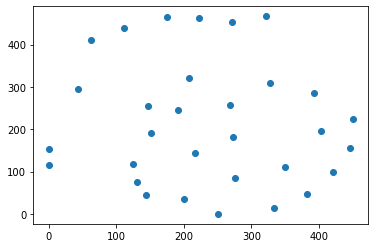

In [2]:
import matplotlib.pyplot as plt
plt.plot(params_dict["X"],params_dict["Y"],"o")

In [3]:
n = params_dict['num_nodes'] # number of nodes in graph

nodes = range(1, n + 1) # nodes will be indexed 1,...,n (unlike usually Python indexing)
edges = [tuple(l) for l in params_dict['links']] # links in network

# Pairs of nodes/customers which have communication demand between them
demand_pairs = [tuple(p) for p in params_dict['demand_pairs']] 

# List of mean demand for each demand pair (in same order of demand_pairs)
demand_mean = params_dict['demand_ms'] # Distribution is Gamma(μ, 1/μ) (where second parameter is scale rather than rate)


# Routes gives set of valid routes for each demand pair
# routes[i] gives the set of the routes for the i-th demand pair
# and each route is defined by a set of edges
routes_list = params_dict['routes']
routes=[]
for (i, p) in enumerate(demand_pairs):
    routes.append([])
    for rs in routes_list[i]:
        routes[i].append([edges[l-1] for l in rs])

# List containing existing capacity for each link/edge
e = params_dict['existing_capacity']
# Maximum total additional capacity
b = params_dict['total_extra_capacity']

The following cell defines a function for sampling sets of scenarios. Note that demand has a Gamma distribution and takes as input the means of the Gamma distribution and the number of required scenarios. It returns the scenario set as a list of vectors.

In [4]:
from scipy.stats import gamma
from typing import List

def sample_scenarios(num_scen : int, demand_mean : List[float]) -> List[np.array]:
    scen_set = []
    for s in range(num_scen):
        #scen = gamma.rvs(np.array(demand_mean), scale=1/np.array(demand_mean))
        scen=np.array([gamma.rvs(mu, 1/mu) for mu in demand_mean])
        scen_set.append(scen)
    return scen_set

The following function implements the recourse function (denoted `h(x,d)` in the paper).

In [5]:
from gurobipy import Model, GRB, tupledict, quicksum

def solve_tnp_recourse(edges, x, e, demand_pairs, routes, demand_scenario):
    m = Model()

    m.Params.outputFlag=0 # Change to 1 if you want to see output from Gurobi

    num_edges = len(edges)
    num_dem_pairs = len(demand_pairs)
    num_routes = [len(r) for r in routes]

    # Second stage
    f = tupledict()
    for i in range(num_dem_pairs):
        for ri in range(num_routes[i]):
            f[i,ri] = m.addVar(name='f[{},{}]'.format(i, ri))
                
    dem_unsat = m.addVars(num_dem_pairs)
    for (li, l) in enumerate(edges):
        edge_flow = quicksum(f[i,ri] for i in range(num_dem_pairs)
                             for (ri, r) in enumerate(routes[i]) if l in r)
        m.addConstr(edge_flow <= x[li] + e[li])

    for i in range(num_dem_pairs):
        total_flow = quicksum(f[i,ri] for ri in range(num_routes[i]))
        m.addConstr(total_flow + dem_unsat[i] == demand_scenario[i])
            
    m.setObjective(quicksum(dem_unsat[i] for i in range(num_dem_pairs)), GRB.MINIMIZE)
    
    m.optimize()
    return m.objVal, m.getAttr('x', f)

## Deterministic Equivalent

In [6]:
def add_scenario(m,x,f,s, edges,e, num_dem_pairs, routes, new_scenario, ind):
    # ind is scenario index
    num_routes = [len(r) for r in routes]
    
    #Scenario variables
    for i in range(num_dem_pairs):
        for ri in range(num_routes[i]):
            f[i,ri,ind] = m.addVar(name='f[{},{},{}]'.format(i, ri,ind))
                
    for i in range(num_dem_pairs):
        s[i,ind] = m.addVar(name="s[{},{}]".format(i,ind))
    
    #Scenrario constraints
    for (li, l) in enumerate(edges):
        edge_flow = quicksum(f[i,ri,ind] for i in range(num_dem_pairs)
                             for (ri, r) in enumerate(routes[i]) if l in r)
        m.addConstr(edge_flow <= x[li] + e[li])

    for i in range(num_dem_pairs):
        total_flow = quicksum(f[i,ri,ind] for ri in range(num_routes[i]))
        m.addConstr(total_flow + s[i,ind] == new_scenario[i])

In [7]:
def solve_tnp(edges, e, demand_pairs, routes, demand_scenarios, total_capacity):
    m = Model()

    m.Params.outputFlag=0 # Change to 1 if you want to see output from Gurobi

    num_edges = len(edges) # n
    num_dem_pairs = len(demand_pairs) # m
    num_routes = [len(r) for r in routes] #the sum of this list is p
    
    x = m.addVars(num_edges)
    m.addConstr(quicksum(x[i] for i in range(num_edges)) <= total_capacity )
    
    f = dict() # decision variable f_irs
    s = dict() # decision variable s_is
    for ind,scenario in enumerate(demand_scenarios):
        add_scenario(m,x,f,s, edges,e, num_dem_pairs, routes, scenario, ind)

    N = len(demand_scenarios)
    m.setObjective(quicksum(s[i,ind]/N for i in range(num_dem_pairs) for ind in range(N) ), GRB.MINIMIZE)
    m.optimize()
    return m.objVal, m.getAttr('x', x)

In [ ]:
from os import listdir
import pickle as pkl 

fileName = "total_capacities"
total_capacities = np.linspace(0,5000,20)

if fileName in listdir(): 
    with open(fileName,"rb") as f:
        opt_vals_against_capacities = pkl.load(f)
else: 
    N = 300 
    np.random.seed(1)
    opt_x_against_capacities = np.zeros((20, 89))
    for i,total_capacity in enumerate(total_capacities):
        print("Total capacity {}".format(total_capacity))
        demand_scenarios = sample_scenarios(N, demand_mean)
        opt_x_against_capacities[i] = solve_tnp(edges, e, demand_pairs, routes, demand_scenarios, total_capacity)[1]
    with open(fileName,"wb") as f:
        pkl.dump(dict(opt_x_against_capacities),f)

In [ ]:
N = 800
np.random.seed(2)
out_of_sample_scens = sample_scenarios_antithetical(N,demand_mean)
cost = np.zeros( (20,N) )
for i,x in enumerate(opt_x_against_capacities):
    print("Total capacity {}".format(total_capacity))
    for j,scenario in enumerate(out_of_sample_scens):
        cost[i][j] = solve_tnp_recourse(edges, x , e, demand_pairs, routes,scenario)[1]

In [36]:

fileName = "x_tilde.pkl"

if fileName in listdir(): 
    with open(fileName,"rb") as f:
        x_tilde = pkl.load(f)
else: 
    np.random.seed(1)
    N = 1000 
    demand_scenarios = sample_scenarios(N, demand_mean)
    opt_val, x_tilde = solve_tnp(edges, e, demand_pairs, routes, demand_scenarios, b)
    print("Optimal value for N={} is {}".format(N,opt_val))
    with open(fileName,"wb") as f:
        pkl.dump(dict(x_tilde),f)

In [9]:
def out_of_sample_estimate(demand_scenarios,*args):
    G = 0
    for scenario in demand_scenarios:
        opt_val,_ = solve_tnp_recourse(demand_scenario=scenario, *args)
        G += opt_val
    return G/len(demand_scenarios)

In [10]:
def sample_scenarios_antithetical(num_scen, demand_mean):
    scen_set = []
    uniform_sample = np.random.random((num_scen//2, len(demand_mean)))
    def append_scenario(u):
        scen=np.array([ gamma.ppf(ui,a=mu,loc=1/mu) for mu,ui in zip(demand_mean,u) ])
        scen_set.append(scen)
    for u in uniform_sample:
        append_scenario(u)
        append_scenario(1-u)
    if num_scen%2:  append_scenario(np.random.random(len(demand_mean)))
    
    return scen_set

In [11]:
from scipy.stats import t

def optimality_gap(n,m,x_tilde,method):
    z_n = np.zeros(m)
    G_n = np.zeros(m)

    for i in range(m):
        print(".",end="")
        demand_scenarios = method(n, demand_mean)
        z_n[i], _ =  solve_tnp(edges, e, demand_pairs, routes, demand_scenarios, b)
        G_n[i]    =  out_of_sample_estimate(demand_scenarios,edges, x_tilde , e, demand_pairs, routes)
    G_n  -= z_n
    print()
    return G_n 

def extract_statistics(G_n,alpha=0.05):
    sd = np.std(G_n)
    upper_bound = np.mean(G_n)+t.ppf(1-alpha, m-1)/np.sqrt(m)*sd

    return np.mean(G_n),upper_bound

In [12]:
## Estimate of optimality gap using x_tilde (trained at 1000 samples) 
n=5
m=100
np.random.seed(1)
G_n = optimality_gap(n,m,x_tilde,sample_scenarios_antithetical)
print(extract_statistics(G_n))
G_n = optimality_gap(n,m,x_tilde,sample_scenarios)
print(extract_statistics(G_n))

.Academic license - for non-commercial use only - expires 2022-10-10
Using license file C:\Users\aliatimi\gurobi.lic
......................................................................

KeyboardInterrupt: 

In [12]:
def opt_gaps_and_upper_bounds(method,n_vals):
    optimality_gaps = list()
    upper_bounds = list()
    m = 10
    for n in n_vals:   
        print("n={} using {}".format(n,method.__name__), end="")
        G_n = optimality_gap(int(n),m,x_tilde,method)
        gap , ub = extract_statistics(G_n)
        optimality_gaps.append(gap)
        upper_bounds.append(ub)
    return np.array(optimality_gaps), np.array(upper_bounds)

In [13]:
n_vals = np.concatenate((np.linspace(5,50,10),np.linspace(60,100,5)))

In [14]:
fileName = "optimality_gap_ant.pkl"
if fileName in listdir(): 
    with open(fileName,"rb") as f:
        data = pkl.load(f)
        opt_gaps_ant = data["opt_gaps"]
        ubs_ant = data["ubs"]
else: 
    np.random.seed(1)
    opt_gaps_ant, ubs_ant = opt_gaps_and_upper_bounds(sample_scenarios_antithetical,n_vals)
    with open(fileName,"wb") as f:
        pkl.dump(dict(opt_gaps=opt_gaps_ant,ubs=ubs_ant),f)

In [15]:
fileName = "optimality_gap_iid.pkl"
if fileName in listdir(): 
    with open(fileName,"rb") as f:
        data = pkl.load(f)
        opt_gaps_iid = data["opt_gaps"]
        ubs_iid = data["ubs"]
else: 
    np.random.seed(1)
    opt_gaps_iid, ubs_iid = opt_gaps_and_upper_bounds(sample_scenarios,n_vals)
    with open(fileName,"wb") as f:
        pkl.dump(dict(opt_gaps=opt_gaps_iid,ubs=ubs_iid),f)

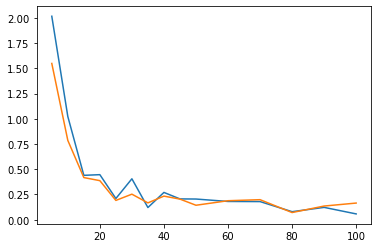

In [16]:
# plt.semilogy(n_vals, opt_gaps_iid )
# plt.semilogy(n_vals, opt_gaps_ant )

plt.plot(n_vals, ubs_iid - opt_gaps_iid)
plt.plot(n_vals,ubs_ant - opt_gaps_ant)

In [18]:
# plt.errorbar(n_vals,optimality_Gaps)

## Risk aversion

Academic license - for non-commercial use only - expires 2022-10-10
Using license file C:\Users\aliatimi\gurobi.lic


(array([0.07033121, 0.03127888, 0.02387559, 0.01665739, 0.01314083,
        0.00906902, 0.0083287 , 0.00351656, 0.00351656, 0.00222099,
        0.00111049, 0.00074033, 0.00037016, 0.00055525, 0.00018508,
        0.        , 0.        , 0.        , 0.        , 0.00018508]),
 array([  0.        ,   5.40300682,  10.80601364,  16.20902045,
         21.61202727,  27.01503409,  32.41804091,  37.82104772,
         43.22405454,  48.62706136,  54.03006818,  59.43307499,
         64.83608181,  70.23908863,  75.64209545,  81.04510226,
         86.44810908,  91.8511159 ,  97.25412272, 102.65712953,
        108.06013635]),
 <BarContainer object of 20 artists>)

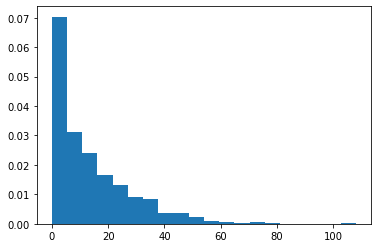

In [17]:
np.random.seed(1)
N = 1000
sample_scens = sample_scenarios_antithetical(N,demand_mean)
opt_vals = np.zeros(N)
for i in range(N):
    opt_vals[i], _ = solve_tnp_recourse(edges, x_tilde, e, demand_pairs, routes, sample_scens[i])
plt.hist(opt_vals,density=True,bins=20)

In [18]:
def solve_tnp_with_beta_cvar(edges, e, demand_pairs, routes, demand_scenarios, total_capacity,beta=0.95):
    m = Model()

    m.Params.outputFlag=0 # Change to 1 if you want to see output from Gurobi

    num_edges = len(edges) # n
    num_dem_pairs = len(demand_pairs) # m
    num_routes = [len(r) for r in routes] #the sum of this list is p
    
    x = m.addVars(num_edges)
    m.addConstr(quicksum(x[i] for i in range(num_edges)) <= total_capacity )
    
    f = dict() # decision variable f_irs
    s = dict() # decision variable s_is
    for ind,scenario in enumerate(demand_scenarios):
        add_scenario(m,x,f,s, edges,e, num_dem_pairs, routes, scenario, ind)
    
    N = len(demand_scenarios)
    alpha = m.addVar(name="alpha")    
    u = m.addVars(N)
    
    m.addConstrs(u[ind] - quicksum(s[i,ind] for i in range(num_dem_pairs) ) + alpha >= 0 for ind in range(N)) 
    m.setObjective(alpha + 1/(1-beta) * 1/N * quicksum(u[ind] for ind in range(N)) ,GRB.MINIMIZE)
    m.optimize()
    return m.objVal, m.getAttr('x', x), m.getAttr('x',s), m.getVarByName("alpha").x

In [39]:
fileName = "x_tilde_cvar_0.8.pkl"

if fileName in listdir(): 
    with open(fileName,"rb") as f:
        x_tilde = pkl.load(f)
else: 
    np.random.seed(1)
    N = 1500
    demand_scenarios = sample_scenarios_antithetical(N, demand_mean)
    x_tilde_cvar = solve_tnp_with_beta_cvar(edges, e, demand_pairs, routes, demand_scenarios, b,beta=0.8)[1]
    with open(fileName,"wb") as f:
        pkl.dump(dict(x_tilde_cvar),f)

In [37]:
np.random.seed(1)
N = 2000
sample_scens = sample_scenarios_antithetical(N,demand_mean)
opt_vals = np.zeros(N); opt_vals_cvar = np.zeros(N)
for i in range(N):
    opt_vals[i], _ = solve_tnp_recourse(edges, x_tilde, e, demand_pairs, routes, sample_scens[i])
    opt_vals_cvar[i], _ = solve_tnp_recourse(edges, x_tilde_cvar, e, demand_pairs, routes, sample_scens[i])

Expected out of sample loss for beta=0  is 13.59155929096133
Expected out of sample loss for beta=0.5 is 13.611655641329252


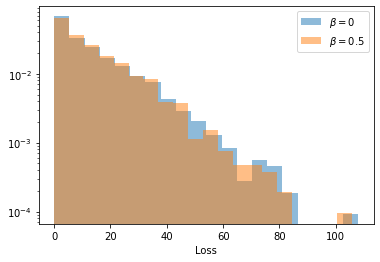

In [38]:
plt.hist(opt_vals,density=True,bins=20,alpha=0.5,log=True)
plt.hist(opt_vals_cvar,density=True,bins=20,alpha=0.5,log=True)
plt.xlabel("Loss")
plt.legend([r'$\beta=0$',r'$\beta=0.5$'])
# plt.savefig("cvar_histogram.pdf",format="pdf")
print('Expected out of sample loss for beta=0  is {}'.format(np.mean(opt_vals)))
print('Expected out of sample loss for beta=0.5 is {}'.format(np.mean(opt_vals_cvar)))

In [29]:
def get_expected_loss(s, num_scen):
    num_dem_pairs = len(demand_pairs) 
    return sum(s[i,ind] for i in range(num_dem_pairs) for ind in range(num_scen))/num_scen

In [30]:
N=200
np.random.seed(1)
demand_scenarios = sample_scenarios(N, demand_mean)
opt_val_cvar , _ , opt_s,opt_alpha = solve_tnp_with_beta_cvar(edges, e, demand_pairs, routes, demand_scenarios, b,beta=0.5)
opt_val = solve_tnp(edges, e, demand_pairs, routes, demand_scenarios, b)[0]
print(get_expected_loss(opt_s, N))
print(opt_val)

15.357294002751603
11.930741176551203


In [90]:
N=100
np.random.seed(1)
demand_scenarios = sample_scenarios(N, demand_mean)
opt_val, _ = solve_tnp_with_beta_cvar(edges, e, demand_pairs, routes, demand_scenarios, b,beta=0)
print("Optimal value for N={} using beta-cvar with beta=0 is {}".format(N,opt_val))
opt_val, _ = solve_tnp(edges, e, demand_pairs, routes, demand_scenarios, b)
print("Optimal value for N={} using the original tnp formulation is {}".format(N,opt_val))
# Note that they have the same optimal value since for beta = 0 the beta-cvar problem
# reduces to the original problem

Optimal value for N=100 using beta-cvar with beta=0 is 11.743300463844731
Optimal value for N=100 using the original tnp formulation is 11.743300463844427


In [88]:
np.random.seed(1)
for _ in range(5):
    N = 300
    demand_scenarios = sample_scenarios(N, demand_mean)
    opt_val, x_tilde = solve_tnp_with_beta_cvar(edges, e, demand_pairs, routes, demand_scenarios, b,beta=0.95)
    print("Optimal value for N={} is {}".format(N,opt_val))

Optimal value for N=300 is 46.331569589061644
Optimal value for N=300 is 37.584383934054685
Optimal value for N=300 is 43.00886973739474
Optimal value for N=300 is 41.47940375005446
Optimal value for N=300 is 47.05334284665034


In [96]:
N=200
M=5

beta_vals = np.linspace(0,0.95,20)
opt_vals = np.zeros((len(beta_vals),M))

np.random.seed(1)
for i,beta in enumerate(beta_vals):
    print("beta={}".format(round(beta,3)))
    for j in range(M):
        demand_scenarios = sample_scenarios(N, demand_mean)
        opt_val, _ = solve_tnp_with_beta_cvar(edges, e, demand_pairs, routes, demand_scenarios, b,beta)
        opt_vals[i,j] = opt_val
#     print("Optimal value for beta={} is {}".format(beta,opt_val))

beta=0.0
beta=0.049999999999999996
beta=0.09999999999999999


KeyboardInterrupt: 

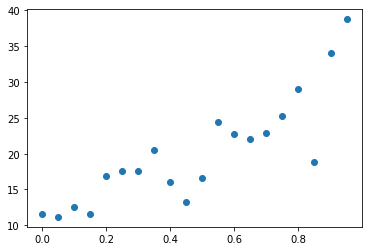

In [94]:
plt.plot(beta_vals,opt_vals,"o",color="blue")